In [1]:
import obspy
from obspy import read
from obspy import UTCDateTime as utc
from obspy.clients.fdsn import Client
client = Client('IRIS')

import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
#Make folder for cleaned data
! mkdir data/clean
filepath = os.getcwd() + '/data/clean/'
raw_filepath = os.getcwd() + '/data/raw/'

mkdir: data/clean: File exists


### Cleaning/Processing Steps
The data will be pre-processed in the manner described in Zali et al., downsampling to a rate of 8 Hz.

*Read in mseed files <br>
*Check all are the same length <br>
*Demean and detrend <br>
*Anti-alias filter and downsample data to 8 Hz

In [3]:
#demean, detrend, lowpass filter, and downsample

def process(st, buffer, target_freq): #freq is the original sampling frequency
    tr = st[0].copy()

    #demean and detrend
    tr.detrend('demean')
    tr.detrend('linear')

    #taper data (to specified taper buffer)
    tr.taper(max_percentage=0.05)

    #lowpass filter data to avoid aliasing when downsampling
    tr.filter('lowpass', freq=2*target_freq, zerophase=True)

    #resample to 8 Hz
    tr.resample(target_freq, no_filter=True)

    #trim off tapered edges
    tr.trim(starttime=tr.stats.starttime+buffer, endtime=tr.stats.endtime-buffer)

    return(tr)

In [16]:
#read in data, process, save cleaned data and figures
length = np.array([])

#for i in range(100):
for i in [96]:
    i += 1
    mseed_name = str(i)+'_sitkin.mseed'
    st = read(raw_filepath+mseed_name)

    #parameters for processing function
    buffer = 60*60*24*0.05 #seconds
    target_freq = 8

    #do processing
    tr = process(st, buffer, target_freq)

    #save trace to mseed again
    tr.write(filepath+str(i)+'_cleaned.mseed', format='MSEED')

    #add data length to array
    length = np.append(length, len(tr.data))

    #plot and save figures
    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)
    ax.plot(tr.times('relative'), tr.data, c='k')
    ax.set_title('Data for Day '+mseed_name.split('_')[0])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Counts')
    ax.set_xlim(0, len(tr.data)/target_freq)
    ax.grid()
    plt.tight_layout()
    plt.savefig(filepath+'Day'+mseed_name.split('_')[0]+'.png')
    plt.close();
    break

97


/opt/anaconda3/envs/array/lib/python3.12/site-packages/obspy/io/mseed/core.py:773: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


### Zoom in on day 97 spike

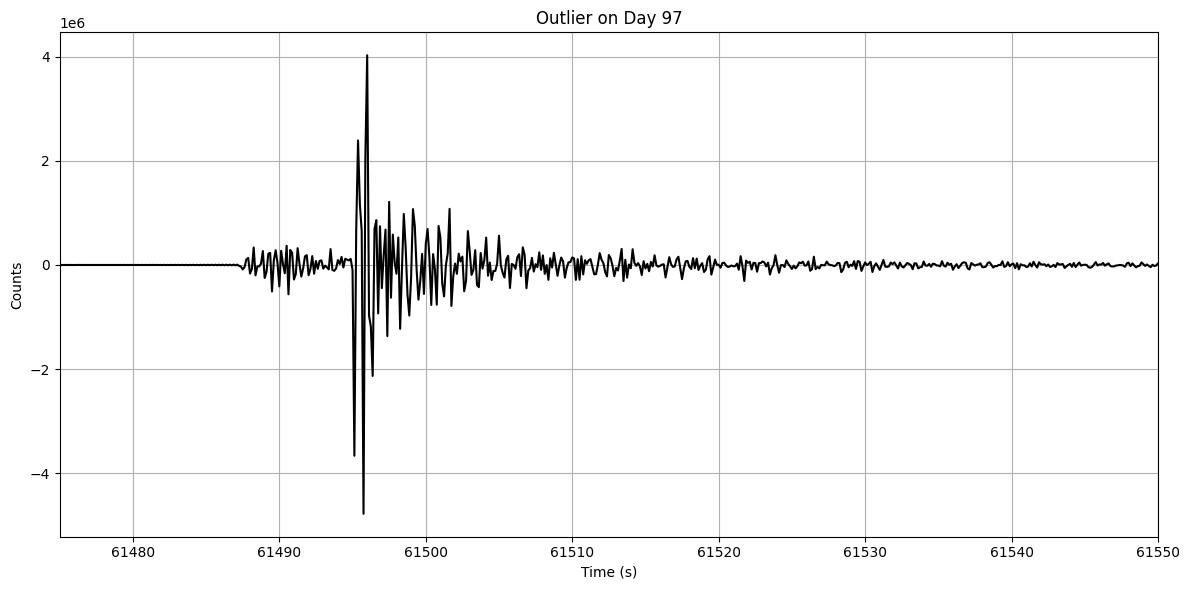

In [26]:
mseed_name = '97_sitkin.mseed'
st = read(raw_filepath+mseed_name)
i
#parameters for processing function
buffer = 60*60*24*0.05 #seconds
target_freq = 8

#do processing
tr = process(st, buffer, target_freq)

#plot and save figures
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
ax.plot(tr.times('relative'), tr.data, c='k')
ax.set_title('Outlier on Day '+mseed_name.split('_')[0])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Counts')
ax.set_xlim(61475, 61550)
ax.grid()
plt.tight_layout()

Save simple time series plots to visually inspect for outliers/data issues not a simple way to remove outliers algorithmically, day 97 for example has extremely impulsive events that by sheer amplitude look like malfunctions, but are real.

In the absence of evidence of instrument malfunction, these outliers are left in so as to more accurately represent eruptive activity.

In [23]:
#check that all values in length are equal
np.unique(length)

array([691200.])

This is the correct number of points for 24 hours of data sampled at 8 Hz. Check this is constant for your data or it will cause irregularities later on!